In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_sin, make_dataset_sin
from polar_coord import make_model_sin_math, make_model_odd

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

In [6]:
# Make datasets for sin
n = 3600
data_sin = make_data_sin(n)
ds_p2c, ds_c2p, d2_p2p, ds_c2c = make_dataset_sin(n)

In [7]:
# Unpack one example batch
# theta, y = list(ds_p2c.take(1))[0]
# theta, y = theta.numpy(), y.numpy()

# Review data contents
# print(f'theta: min={np.min(theta):+8.5}, max={np.max(theta):+8.5}')
# print(f'    y: min={np.min(y):+8.5}, max={np.max(y):+8.5}')

In [8]:
theta = data_sin['theta']
y = data_sin['y']

In [9]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_model_sin_math()

In [10]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

# Set save_freq in terms of SAMPLES; this is every 500 epochs
epoch_size = n+1
save_freq = 500 * epoch_size

In [11]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [12]:
# Evaluate the p2c math model
math_p2c.evaluate(ds_p2c)

1/1 [==============================] - 0s 61ms/step - loss: 4.6015e-16 - mean_absolute_error: 8.6908e-09


[4.601469428267544e-16, 8.690771e-09]

In [13]:
# Evaluate the c2p math model
math_c2p.evaluate(ds_c2p)

1/1 [==============================] - 0s 54ms/step - loss: 6.4945e-13 - mean_absolute_error: 9.5310e-08


[6.494469675585868e-13, 9.5309716e-08]

In [14]:
# Evaluate the p2p math model
math_p2p.evaluate(theta, theta)

3601/3601 [==============================] - 0s 36us/sample - loss: 6.4904e-13 - mean_absolute_error: 9.3136e-08


[6.490446467481708e-13, 9.313639e-08]

In [15]:
# Evaluate the c2c math model
math_c2c.evaluate(y, y)

3601/3601 [==============================] - 0s 38us/sample - loss: 7.0153e-16 - mean_absolute_error: 1.2527e-08


[7.01525834862032e-16, 1.2526948e-08]

In [196]:
def compile_and_fit(model, ds, epochs, loss, optimizer, metrics, save_freq):
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model_name = model.name
    filepath=f'../models/polar_{model_name}.h5'

    # Create callbacks
    interval = epochs // 20
    cb_log = EpochLoss(interval=interval)
    cb_time = TimeHistory()
    cb_ckp = keras.callbacks.ModelCheckpoint(
            filepath=filepath, 
            save_freq=save_freq,
            save_best_only=True,
            save_weights_only=True,
            monitor='loss',
            verbose=0)    
    cb_early_stop = keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=1.0E-8,
            patience=1000,
            verbose=1,
            restore_best_weights=True)    
    callbacks = [cb_log, cb_time, cb_ckp, cb_early_stop]
    
    # Fit the model
    hist = model.fit(ds, epochs=epochs, callbacks=callbacks, verbose=0)
    # Add the times to the history
    hist.history['time'] = cb_time.times
    
    # Restore the model to the best weights
    model.load_weights(filepath)

    return hist

In [233]:
def plot_pred_sin(model, theta):
    # Predictions of the model
    y_pred = model.predict(theta)
    y_pred = y_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title('$y = sin(\\theta)$')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$y$')
    ax.set_xlim(-np.pi/2.0, np.pi/2.0)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.set_ylim(-1.05, 1.05)
    ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, y, color='blue', label='$\sin(\\theta)$', linewidth=4.0)
    ax.plot(theta, y_pred, color='red', label='NN$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [198]:
def plot_error_sin(model, theta):
    # Predictions of the model
    y_pred = model.predict(theta)
    y_pred = y_pred.reshape((-1,))
    error = y_pred - np.sin(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title('$y = sin(\\theta)$')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('error = $\sin(\theta)$ - NN($\theta$)')
    ax.set_xlim(-np.pi/2.0, np.pi/2.0)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.plot(theta, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

In [199]:
# Build the NN model of y=sin(theta)
model_sin_64 = make_model_odd(func_name='sin', hidden_sizes=[64])

In [200]:
# keras.utils.plot_model(model_sin_64)

In [201]:
# model_sin_64.summary()

In [202]:
hist_sin_64 = compile_and_fit(model=model_sin_64, 
                              ds=ds_p2c, 
                              epochs=10000,
                              loss=keras.losses.MeanSquaredError(), 
                              optimizer=keras.optimizers.Adam(learning_rate=1.0E-3),
                              # optimizer=keras.optimizers.Adadelta(learning_rate=1.0E-1),
                              # optimizer=keras.optimizers.SGD(learning_rate=1.0E-3, momentum=0.5),
                              metrics=metrics,
                              save_freq=save_freq)

Epoch 0001; loss 4.70e-01; elapsed 0:00:00
Epoch 0500; loss 2.47e-04; elapsed 0:00:08
Epoch 1000; loss 7.17e-05; elapsed 0:00:15
Epoch 1500; loss 3.79e-05; elapsed 0:00:23
Epoch 2000; loss 2.09e-05; elapsed 0:00:31
Epoch 2500; loss 1.21e-05; elapsed 0:00:38
Epoch 3000; loss 7.38e-06; elapsed 0:00:46
Epoch 3500; loss 4.55e-06; elapsed 0:00:53
Epoch 4000; loss 2.88e-06; elapsed 0:01:00
Epoch 4500; loss 1.89e-06; elapsed 0:01:07
Epoch 5000; loss 7.03e-06; elapsed 0:01:14
Epoch 5500; loss 9.29e-07; elapsed 0:01:21
Epoch 6000; loss 6.64e-07; elapsed 0:01:28
Epoch 6500; loss 4.78e-07; elapsed 0:01:35
Epoch 7000; loss 4.92e-07; elapsed 0:01:42
Epoch 7500; loss 4.38e-07; elapsed 0:01:49
Epoch 8000; loss 3.66e-07; elapsed 0:01:56
Epoch 8500; loss 1.47e-07; elapsed 0:02:03
Epoch 9000; loss 1.19e-07; elapsed 0:02:10
Epoch 9500; loss 2.66e-07; elapsed 0:02:17
Epoch 10000; loss 8.46e-08; elapsed 0:02:24


In [205]:
model_sin_64.evaluate(ds_p2c)

1/1 [==============================] - 0s 83ms/step - loss: 8.4595e-08 - mean_absolute_error: 2.5695e-04


[8.459478095801387e-08, 0.00025695434]

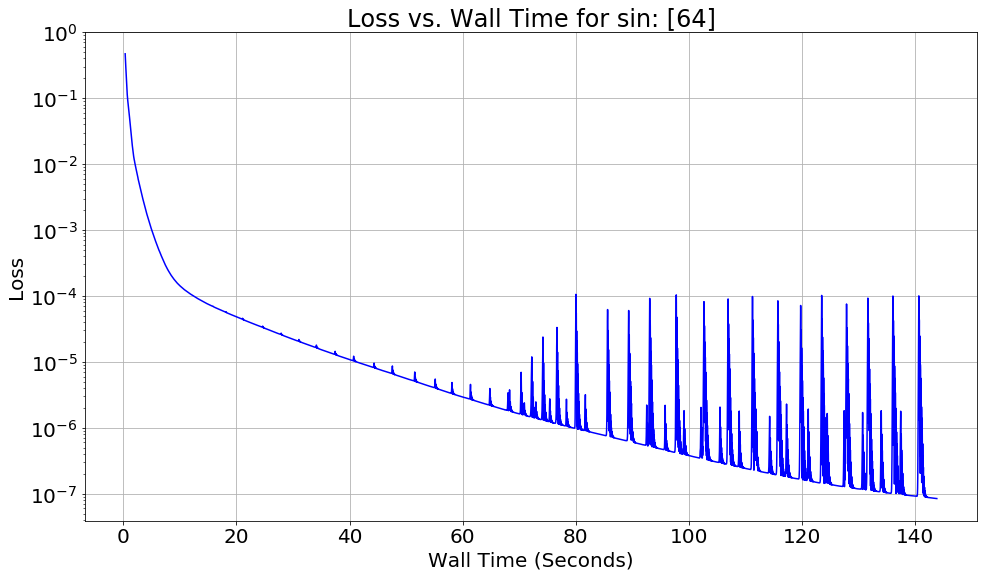

In [206]:
fig, ax = plot_loss_hist(hist_sin_64, 'sin: [64]')

In [104]:
# fig, ax = plot_pred_sin(model_sin_64, theta)

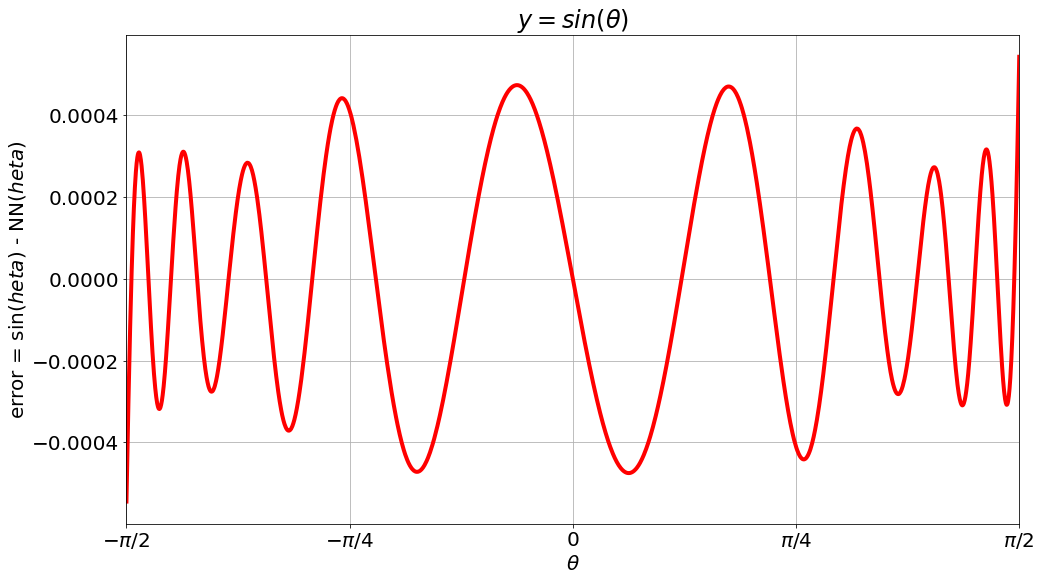

In [207]:
fig, ax = plot_error_sin(model_sin_64, theta)

In [208]:
model_sin_16_16 = make_model_odd(func_name='sin', hidden_sizes=[16, 16])

In [209]:
# model_sin_16_16.summary()

In [210]:
hist_sin_16_16 = compile_and_fit(model=model_sin_16_16, 
                                 ds=ds_p2c, 
                                 epochs=10000,
                                 loss=keras.losses.MeanSquaredError(), 
                                 optimizer=keras.optimizers.Adam(learning_rate=1.0E-3),
                                 # optimizer=keras.optimizers.Adadelta(learning_rate=1.0E-1),
                                 # optimizer = keras.optimizers.SGD(learning_rate=1.0E-2, momentum=0.50),
                                 metrics=metrics,
                                 save_freq=save_freq)

Epoch 0001; loss 7.69e-01; elapsed 0:00:01
Epoch 0500; loss 1.08e-04; elapsed 0:00:09
Epoch 1000; loss 4.07e-05; elapsed 0:00:17
Epoch 1500; loss 1.52e-05; elapsed 0:00:25
Epoch 2000; loss 5.06e-06; elapsed 0:00:33
Epoch 2500; loss 1.88e-06; elapsed 0:00:40
Epoch 3000; loss 7.98e-07; elapsed 0:00:48
Epoch 3500; loss 4.49e-07; elapsed 0:00:55
Epoch 4000; loss 3.32e-07; elapsed 0:01:02
Epoch 4500; loss 2.81e-07; elapsed 0:01:09
Epoch 5000; loss 2.40e-07; elapsed 0:01:16
Epoch 5500; loss 2.14e-07; elapsed 0:01:24
Epoch 6000; loss 1.95e-07; elapsed 0:01:31
Epoch 6500; loss 7.66e-07; elapsed 0:01:38
Epoch 7000; loss 1.65e-07; elapsed 0:01:45
Epoch 7500; loss 3.78e-06; elapsed 0:01:52
Epoch 8000; loss 1.30e-06; elapsed 0:02:00
Epoch 8500; loss 6.10e-06; elapsed 0:02:07
Epoch 9000; loss 3.62e-05; elapsed 0:02:14
Epoch 9500; loss 1.09e-07; elapsed 0:02:21
Epoch 10000; loss 1.00e-07; elapsed 0:02:28


In [211]:
model_sin_16_16.evaluate(ds_p2c)

1/1 [==============================] - 0s 99ms/step - loss: 1.0038e-07 - mean_absolute_error: 2.3105e-04


[1.0037979336630087e-07, 0.00023104712]

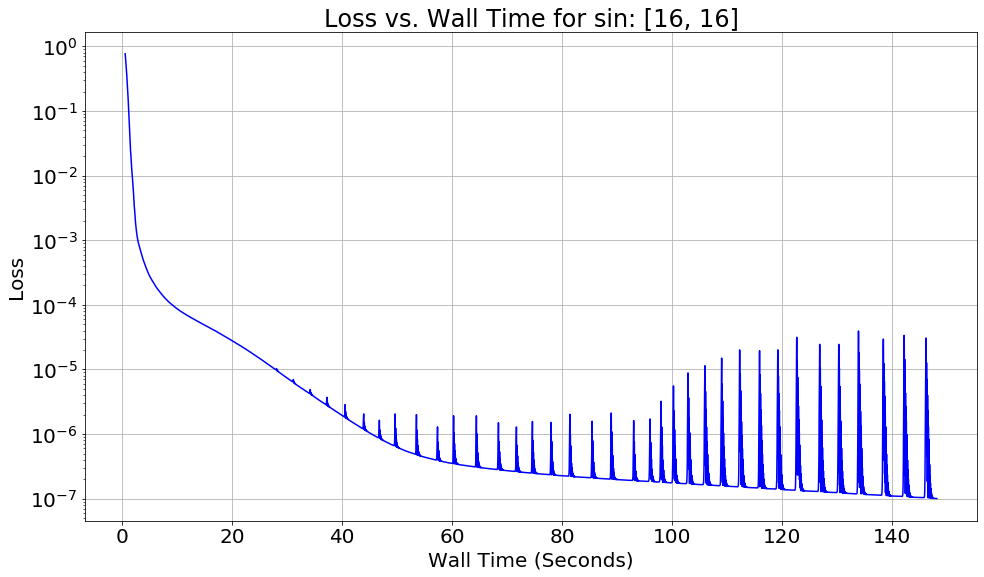

In [212]:
fig, ax = plot_loss_hist(hist_sin_16_16, 'sin: [16, 16]')

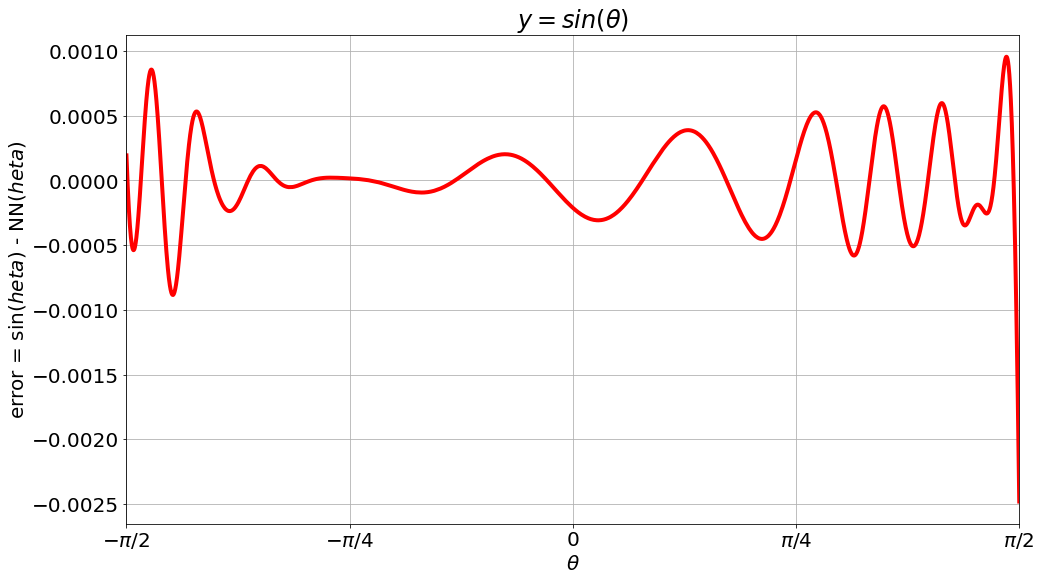

In [213]:
fig, ax = plot_error_sin(model_sin_16_16, theta)

In [214]:
model_sin_32_32 = make_model_odd(func_name='sin', hidden_sizes=[32, 32])

In [215]:
model_sin_32_32.summary()

Model: "model_sin_[32, 32]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
theta3 (Lambda)                 (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta5 (Lambda)                 (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
theta7 (Lambda)                 (None, 1)            0           theta[0][0]                      
_________________________________________________________________________________

In [216]:
hist_sin_32_32 = compile_and_fit(model=model_sin_32_32, 
                                 ds=ds_p2c, 
                                 epochs=10000,
                                 loss=keras.losses.MeanSquaredError(), 
                                 optimizer=keras.optimizers.Adam(),
                                 metrics=metrics,
                                 save_freq=save_freq)

Epoch 0001; loss 7.04e-01; elapsed 0:00:00
Epoch 0500; loss 1.21e-04; elapsed 0:00:08
Epoch 1000; loss 2.20e-05; elapsed 0:00:16
Epoch 1500; loss 1.09e-05; elapsed 0:00:24
Epoch 2000; loss 5.83e-06; elapsed 0:00:32
Epoch 2500; loss 2.58e-06; elapsed 0:00:39
Epoch 3000; loss 8.98e-07; elapsed 0:00:47
Epoch 3500; loss 2.80e-07; elapsed 0:00:54
Epoch 4000; loss 8.25e-08; elapsed 0:01:01
Epoch 4500; loss 4.91e-08; elapsed 0:01:08
Epoch 5000; loss 4.03e-08; elapsed 0:01:15
Epoch 5500; loss 3.51e-08; elapsed 0:01:22
Epoch 6000; loss 3.58e-08; elapsed 0:01:29
Restoring model weights from the end of the best epoch.
Epoch 06122: early stopping


In [37]:
model_sin_32_32.evaluate(ds_p2c)

1/1 [==============================] - 0s 81ms/step - loss: 2.2152e-06 - mean_absolute_error: 0.0012


[2.2152087240101537e-06, 0.001245365]

(<Figure size 1152x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1df14f9ecf8>)

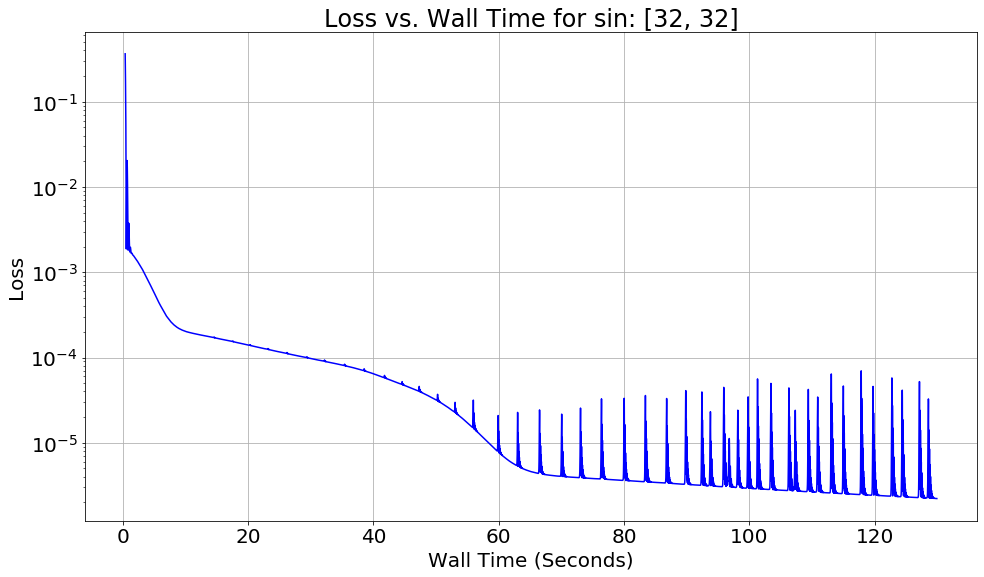

In [35]:
plot_loss_hist(hist_sin_32_32, 'sin: [32, 32]')

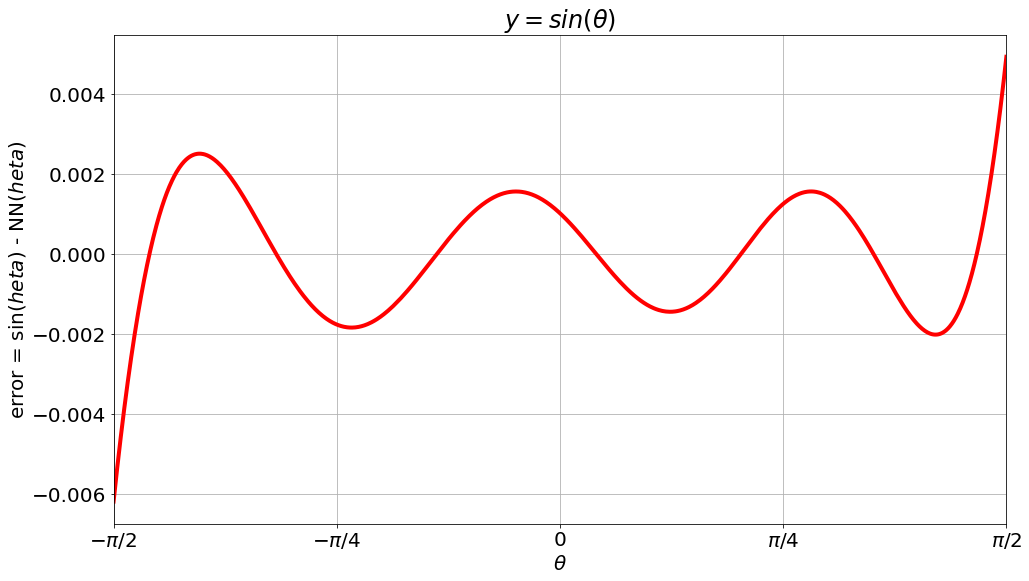

In [36]:
fig, ax = plot_error_sin(model_sin_32_32, theta)

In [217]:
def make_model_odd(func_name, hidden_sizes):
    """
    Neural net model of odd functions, e.g. y = sin(theta)
    Example call: model_sin_16_16 = make_model_odd(sin, [16, 16])
    """
    # Input layer
    theta = keras.Input(shape=(1,), name='theta')

    # Number of hidden layers
    num_layers = len(hidden_sizes)

    # Feature augmentation; odd powers up to 7
    theta3 = keras.layers.Lambda(lambda x: tf.pow(x, 3), name='theta3')(theta)
    theta5 = keras.layers.Lambda(lambda x: tf.pow(x, 5), name='theta5')(theta)
    theta7 = keras.layers.Lambda(lambda x: tf.pow(x, 7), name='theta7')(theta)
    
    # Augmented feature layer
    phi_0 = keras.layers.concatenate(inputs=[theta, theta3, theta5, theta7], name='phi_0')
    
    # Dense feature layers

    # First hidden layer
    phi_1 = keras.layers.Dense(units=hidden_sizes[0], activation='tanh', name='phi_1')(phi_0)

    # Second hidden layer if applicable
    phi_2 = None
    if num_layers > 1:
        phi_2 = keras.layers.Dense(units=hidden_sizes[1], activation='tanh', name='phi_2')(phi_1)

    # Lookup table for last feature layer
    phi_tbl = {1: phi_1,
               2: phi_2}

    # The last feature layer
    phi_n = phi_tbl[num_layers]

    # Output layer
    y = keras.layers.Dense(units=1, name='y')(phi_n)

    # Wrap into a model
    model_name = f'model_{func_name}_' + str(hidden_sizes)
    model = keras.Model(inputs=theta, outputs=y, name=model_name) 
    return model

In [220]:
model_arcsin_16_16 = make_model_odd(func_name='arcsin', hidden_sizes=[16, 16])

In [221]:
hist_arcsin_16_16 = compile_and_fit(model=model_arcsin_16_16, 
                                 ds=ds_c2p, 
                                 epochs=10000,
                                 loss=keras.losses.MeanSquaredError(), 
                                 optimizer=keras.optimizers.Adam(learning_rate=1.0E-3),
                                 metrics=metrics,
                                 save_freq=save_freq)

Epoch 0001; loss 3.54e-01; elapsed 0:00:00
Epoch 0500; loss 1.07e-03; elapsed 0:00:08
Epoch 1000; loss 6.18e-04; elapsed 0:00:16
Epoch 1500; loss 4.26e-04; elapsed 0:00:24
Epoch 2000; loss 3.00e-04; elapsed 0:00:33
Epoch 2500; loss 2.27e-04; elapsed 0:00:40
Epoch 3000; loss 1.86e-04; elapsed 0:00:48
Epoch 3500; loss 1.62e-04; elapsed 0:00:56
Epoch 4000; loss 1.46e-04; elapsed 0:01:04
Epoch 4500; loss 1.34e-04; elapsed 0:01:12
Epoch 5000; loss 1.23e-04; elapsed 0:01:20
Epoch 5500; loss 1.12e-04; elapsed 0:01:27
Epoch 6000; loss 1.01e-04; elapsed 0:01:35
Epoch 6500; loss 8.97e-05; elapsed 0:01:43
Epoch 7000; loss 7.91e-05; elapsed 0:01:51
Epoch 7500; loss 6.93e-05; elapsed 0:01:58
Epoch 8000; loss 6.09e-05; elapsed 0:02:06
Epoch 8500; loss 5.42e-05; elapsed 0:02:14
Epoch 9000; loss 4.94e-05; elapsed 0:02:21
Epoch 9500; loss 4.57e-05; elapsed 0:02:29
Epoch 10000; loss 4.26e-05; elapsed 0:02:36


In [223]:
model_arcsin_16_16.evaluate(ds_c2p)

1/1 [==============================] - 0s 89ms/step - loss: 4.2596e-05 - mean_absolute_error: 0.0040


[4.259559864294715e-05, 0.0039870916]

In [231]:
def plot_pred_arcsin(model, y):
    # Predictions of the model
    theta_pred = model.predict(y)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title('$\\theta = \\arcsin(y)$')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(-np.pi/2.0, np.pi/2.0)
    ax.set_yticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_yticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.plot(y, theta, color='blue', label='$\\arcsin(y)$', linewidth=4.0)
    ax.plot(y, theta_pred, color='red', label='NN$(y)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [ ]:
def plot_pred_arcsin(model, y):
    # Predictions of the model
    theta_pred = model.predict(y)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title('$\\theta = \\arcsin(y)$')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(-np.pi/2.0, np.pi/2.0)
    ax.set_yticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_yticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.plot(y, theta, color='blue', label='$\\arcsin(y)$', linewidth=4.0)
    ax.plot(y, theta_pred, color='red', label='NN$(y)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [236]:
def plot_error_arcsin(model, y):
    # Predictions of the model
    theta_pred = model.predict(y)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title('$\\theta = \\arcsin(y)$')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(y, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

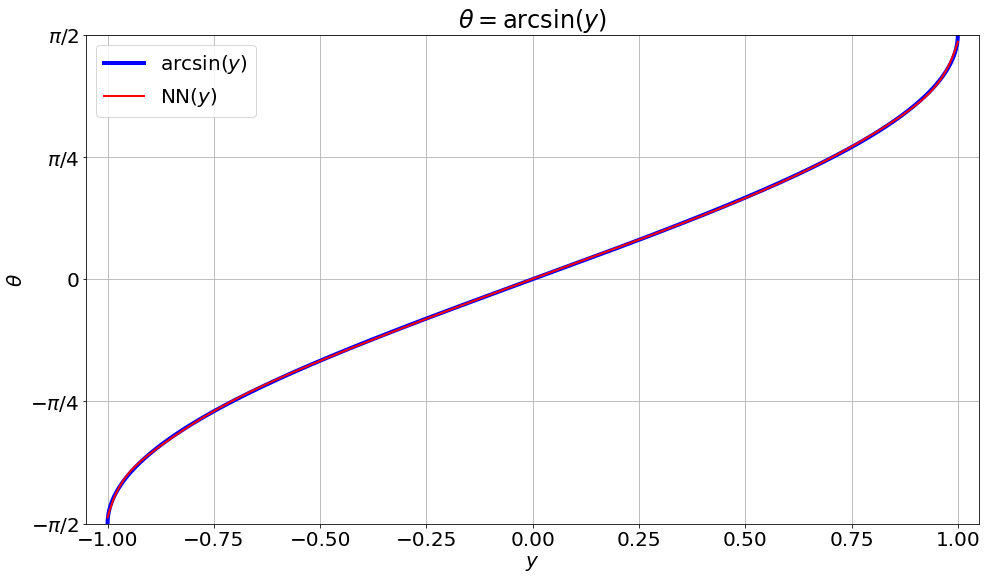

In [237]:
fig, ax = plot_pred_arcsin(model_arcsin_16_16, y)

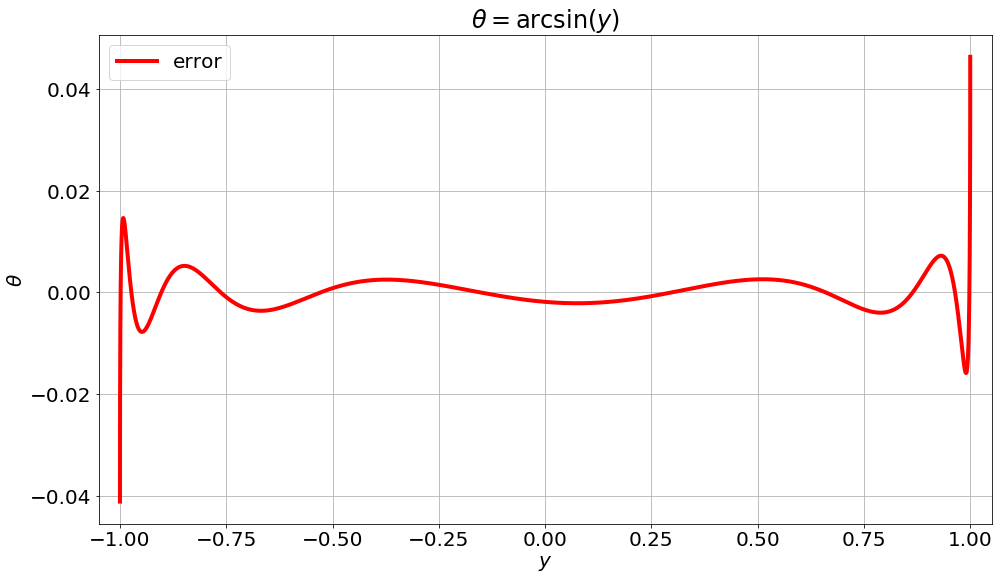

In [238]:
fig, ax = plot_error_arcsin(model_arcsin_16_16, y)